In [16]:
import os
import random
import shutil
!pip install labelme tensorflow opencv-python matplotlib albumentations

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [25]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

2023-11-23 22:55:47.999251: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-23 22:55:48.011631: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-23 22:55:48.059662: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-23 22:55:48.059843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-23 22:55:48.088516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [ ]:
!mkdir -p data/{train,test,val}/{images,labels}

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [11]:
import os
images = tf.data.Dataset.list_files(os.path.join('data', 'images', '*.jpg'), shuffle=False)

In [12]:
images.as_numpy_iterator().next()

b'data/images/0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg'

In [49]:
def load_image(path): 
    byte_img = tf.io.read_file(path)
    loaded_image = tf.io.decode_jpeg(byte_img)
    return loaded_image

In [14]:
images = images.map(load_image)

In [15]:
images.as_numpy_iterator().next()

array([[[105,  98,  92],
        [107, 100,  94],
        [105,  97,  94],
        ...,
        [113, 102, 100],
        [111, 100,  98],
        [112, 101,  99]],

       [[105,  98,  92],
        [108, 101,  95],
        [106,  98,  95],
        ...,
        [113, 102, 100],
        [110,  99,  97],
        [108,  97,  95]],

       [[106,  97,  90],
        [110, 101,  94],
        [111, 102,  97],
        ...,
        [113, 102, 100],
        [110,  99,  97],
        [109,  98,  96]],

       ...,

       [[134, 124,  99],
        [137, 127, 102],
        [140, 129, 107],
        ...,
        [ 66,  62,  50],
        [ 62,  58,  47],
        [ 60,  56,  44]],

       [[137, 125, 101],
        [138, 126, 102],
        [138, 126, 104],
        ...,
        [ 65,  59,  45],
        [ 62,  56,  44],
        [ 63,  57,  43]],

       [[135, 123,  99],
        [137, 125, 101],
        [139, 127, 105],
        ...,
        [ 66,  60,  46],
        [ 65,  57,  44],
        [ 63,  55,  42]]

In [16]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [23]:
plot_images = image_generator.next()

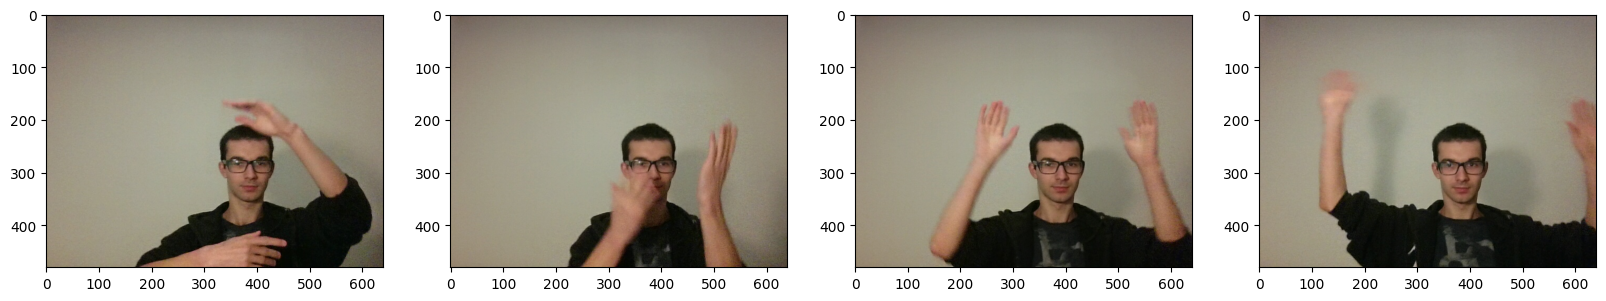

In [24]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# Split Images # https://www.google.com/search?q=linux+move+n+random+files

In [12]:
## split images 
## linux move n random files -> https://stackoverflow.com/questions/14033129/how-to-move-a-given-number-of-random-files-on-unix-linux-os
# !shuf -n 63 -e data/images/* | xargs -i mv {} data/train/images
# !shuf -n 14 -e data/images/* | xargs -i mv {} data/test/images
# !shuf -n 13 -e data/images/* | xargs -i mv {} data/val/images

In [10]:
import os
import shutil
import random


def shuffle_and_move(count: int, data_dir: str):
    source_directory = os.path.join('data', 'images')
    destination_directory = os.path.join('data', data_dir, 'images')
    files = os.listdir(source_directory)
    random.shuffle(files)
    files = files[:count]
    for file in files:
        old_path = os.path.join(source_directory, file)
        new_path = os.path.join(destination_directory, file)
        shutil.move(old_path, new_path)
            

In [11]:
shuffle_and_move(63, 'train')
shuffle_and_move(14, 'test')
shuffle_and_move(13, 'val')

In [13]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):

        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

In [14]:
import albumentations as alb

In [34]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                         alb.HorizontalFlip(p=0.5),
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                        bbox_params=alb.BboxParams(format='albumentations',
                                                   label_fields=['class_labels']))

In [23]:
import cv2

img_name = os.listdir(os.path.join('data', 'train', 'images'))[0]
print(img_name)
img = cv2.imread(os.path.join('data', 'train', 'images', img_name))


0132fc4e-896c-11ee-aed7-df8acdbd3581.jpg


In [26]:
with open(os.path.join('data', 'train', 'labels', img_name.replace('.jpg', '.json')), 'r') as f:
    label = json.load(f)

In [28]:
label['shapes'][0]['points']

[[263.8423645320197, 103.79310344827587],
 [376.6502463054187, 262.90640394088666]]

In [29]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [30]:
coords

[263.8423645320197, 103.79310344827587, 376.6502463054187, 262.90640394088666]

In [31]:
coords = list(np.divide(coords, [640,480,640,480]))

In [32]:
coords

[0.4122536945812808,
 0.21623563218390807,
 0.5885160098522167,
 0.5477216748768472]

In [36]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])

In [40]:
augmented['bboxes'][0][2:]

(0.5547783251231527, 0.7871264367816092)

In [41]:
augmented['bboxes']

[(0.3040941434044882,
  0.4335413245758074,
  0.5547783251231527,
  0.7871264367816092)]

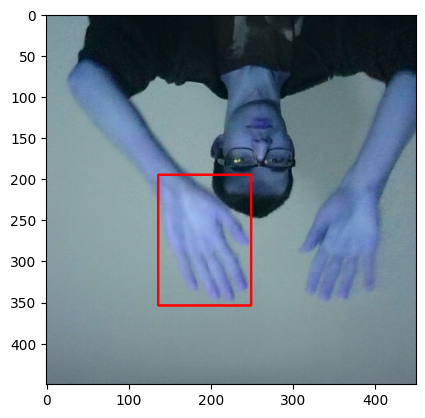

In [42]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

In [43]:
!mkdir -p aug_data/{train,test,val}/{images,labels}

In [45]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0, 0, 0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640, 480, 640, 480]))

        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['hand'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'),
                            augmented['image'])

                annotation = {'image': image}

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0, 0, 0, 0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0, 0, 0, 0]
                    annotation['class'] = 0

                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [46]:
def load_images_into_dataset(dir_name: str):
    loaded_images = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'images', '*.jpg'), shuffle=False)
    loaded_images = loaded_images.map(load_image)
    loaded_images = loaded_images.map(lambda y: tf.image.resize(y, (120, 120)))
    loaded_images = loaded_images.map(lambda y: y / 255)
    return loaded_images

In [50]:
train_images = load_images_into_dataset('train')
test_images = load_images_into_dataset('test')
val_images = load_images_into_dataset('val')

In [ ]:
train_images.as_numpy_iterator().next()

# Prepare Labels

In [53]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [60]:
def load_labels_into_dataset(dir_name: str):
    loaded_labels = tf.data.Dataset.list_files(os.path.join('aug_data', dir_name, 'labels', '*.json'), shuffle=False)
    loaded_labels = loaded_labels.map(lambda y: tf.py_function(load_labels, [y], [tf.int32, tf.float32]))
    return loaded_labels

train_labels = load_labels_into_dataset('train')
test_labels = load_labels_into_dataset('test')
val_labels = load_labels_into_dataset('val')

In [ ]:
train_labels.as_numpy_iterator().next()


# Combine Images and Labels

In [63]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3780, 3780, 840, 840, 780, 780)

In [65]:
def zip_dataset(images_, labels):
    return tf.data.Dataset.zip((images_, labels)).shuffle(len(labels) + 1).batch(8).prefetch(4)

train = zip_dataset(train_images, train_labels)
test = zip_dataset(test_images, test_labels)
val = zip_dataset(val_images, val_labels)

In [67]:
len(train), len(test), len(val)

(473, 105, 98)

In [ ]:
train.as_numpy_iterator().next()[1]

In [71]:
data_samples = train.as_numpy_iterator()

In [82]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


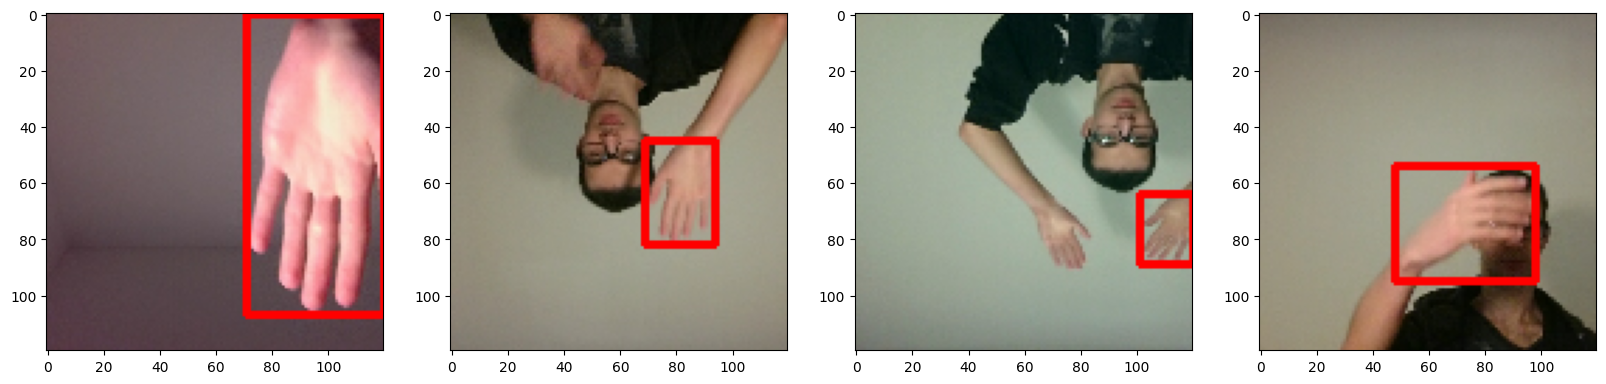

In [83]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
                  tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                  (255, 0, 0), 2)

    ax[idx].imshow(sample_image)